# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.query('file=="streaming.py"').sort_values('start_time', ascending=False).iloc[0]
print(run_info)

path            runs/streaming-N20-P4-050920-154259
start_time                      2020-09-05 15:42:59
num_guesses                                      20
num_parallel                                      4
dim                                               4
opt_delay                                         4
runtime                                           2
runtime_var                                     0.5
file                                   streaming.py
worker_count                                      4
n_evals                                           8
Name: 1, dtype: object


## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
result_data = pd.read_json(os.path.join(run_info['path'], 'results.json'), lines=True)

Plot the time since first result

In [5]:
result_data['walltime'] = result_data['time_result_received'] - result_data['time_created'].min()

Plot the rate at which we aquired new results

## Evaluate Runtimes
Estimate the runtimes of the QC code

In [6]:
result_data['time_running'].describe()

count    20.000000
mean      7.424448
std       3.648920
min       3.294323
25%       4.876657
50%       5.945645
75%       9.551914
max      15.123175
Name: time_running, dtype: float64

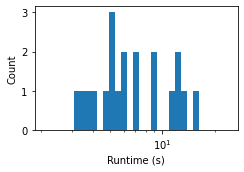

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

min_log = np.log10(result_data.time_running).min()
max_log = np.log10(result_data.time_running).max()
ax.hist(result_data['time_running'], bins=np.logspace(min_log - 0.2, max_log + 0.2, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Count')
fig.tight_layout()

## Plot the Number of Results Being Run at a Time
We can look at the runtime log to get when QC tasks are sent out and arrive

In [8]:
with open(os.path.join(run_info['path'], 'runtime.log')) as fp:
    log_data = pd.DataFrame(f.rstrip() for f in fp)
log_data.rename(columns={0: 'msg'}, inplace=True)
log_data['msg_num'] = log_data['msg'].str.match(r'^[\d]').cumsum()
log_data = log_data.groupby('msg_num').agg({'msg': lambda x: '\n'.join(x)})

In [9]:
log_data['time'], log_data['parsl'], log_data['level'], log_data['content'] = zip(*log_data['msg'].str.split(" - ", 3))

Compute the time since first message

In [10]:
log_data['time'] = pd.to_datetime(log_data['time'])

In [11]:
log_data['walltime'] = (log_data['time'] - log_data['time'].iloc[0]).apply(lambda x: x.total_seconds())

Find the events related to calculations starting and finishing

In [12]:
events = [{'time': 0, 'active_delta': 0}]
events.extend({'time': t, 'active_delta': -1} for t in 
          log_data[log_data['content'].str.match('^Client received a')]['walltime'])
events.extend([{'time': t, 'active_delta': 1} for t in 
               log_data[log_data['content'].str.match('^Client sent a')]['walltime']])
events = pd.DataFrame(events)

Make the results easier to plot

In [13]:
events.sort_values('time', ascending=True, inplace=True)

In [14]:
events['num_active'] = events['active_delta'].cumsum()

Compute worker utilization

In [15]:
events['queue_length'] = events['num_active']

In [16]:
events['utilization'] = np.clip(events['queue_length'] / run_info['worker_count'], 0, 1)

In [17]:
utilization_int = (np.diff(events['time'].values) * events['utilization'].values[:-1]).cumsum()

Compute the cumulative utilization

In [18]:
def cumulative_utilization(time: float) -> float:
    """Compute average utilization over time"""
    # Integrating knowing that we have a piecewise functions
    # Integrate over all of the pieces before the current piece
    past_events = events[events.time <= time]
    if len(past_events) <= 1:
        return 0.0
    past_util = (np.diff(past_events['time'].values) * past_events['utilization'].values[:-1]).sum()
    
    # Integrate the current piece
    current_event = past_events.iloc[-1]
    current_util = (time - current_event.time) * current_event.utilization
    return (past_util + current_util) / time

In [19]:
%%time
times = np.linspace(0, events.time.max(), 1024)
utilization = np.array([cumulative_utilization(x) for x in times])

CPU times: user 779 ms, sys: 3.1 ms, total: 782 ms
Wall time: 791 ms


Plot the queue length and utilization

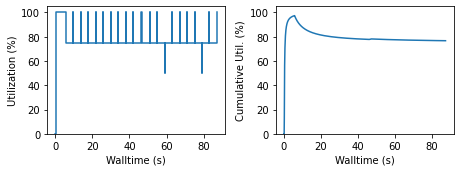

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['time'], events['utilization'] * 100, where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

ax = axs[1]
ax.plot(times, utilization * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Cumulative Util. (%)')
ax.set_ylim(0, 105)

fig.tight_layout()
fig.savefig('utilization.png', dpi=320)